# Understanding and Predicting the King County Housing Market

In [1]:
# Here are the imports we'll need for the notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from yellowbrick.regressor import ResidualsPlot
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
%matplotlib inline

## Data Understanding

In [2]:
# Reading in the data set into variable housing_df and changing the 2nd column into datetime
housing_df = pd.read_csv('./data/kc_house_data.csv', parse_dates=[1])

A lot of the dataframe we are working with will have several columns, so we'll want to use the `display.max_columns` option to prevent pandas from cutting out the middle columns from our outputs.

In [3]:
# Looking at the dataframe to see the overall data organization 
# Here, we make pandas display the whole df, regardless of how many columns it contains
pd.set_option('display.max_columns', None)
housing_df
# Decided to keep id column for future reference, in case of new data addition, as well as checking for duplicates. 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,Average,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


Here we see that there are 21597 rows we have to work with when developing this linear model. Furthermore it seems that there 21 columns, one of which being the identifier column, another being the target column (price), and finally 19 other columns for us to work with.

In [4]:
# Checking data type of each column and looking for nulls
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

Most of our columns turned out well, but at first glance we'll need to address some of the nulls in the waterfront, views, and yr_renovated columns. We'll also need to figure out why sqft_basement is not a numerical data type. Lastly, zipcode is currently a numerical data type, but in order to use it in the model, we'll have to change it into a categorical type.

In [5]:
# We'll look at the descriptive statistics for the df
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


We see here that there some big issues as far as outliers go. For example the max of bedrooms is 33, which would not be a useful data point for our model that is trying to understand the housing market for more traditional homes. We also see huge outliers in both of the sqft_lot columns. Furthermore there are large discrepancies between the mean and median for many of the variables, suggesting a non-normal distribution that we may have to transform.

In [6]:
# Getting the exact counts for the nulls in each column
housing_df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
# Here we see that the nulls from views are a negligible amount,
# So we'll probably just drop the rows with nulls in the view column
((housing_df.view.isna().sum())/(len(housing_df.view))) * 100

0.29170718155299347

In [8]:
# Year renovated has many more null values, but this make sense
# since lots of houses have never been renovated
# We can make a good model without this column, so we'll drop it from our clean df
((housing_df.yr_renovated.isna().sum())/((len(housing_df.yr_renovated)))) * 100

17.78950780200954

In [9]:
# There are also a lot of nulls in this column, but this column could be very useful
# We'll figure out how to clean this later
((housing_df.waterfront.isna().sum())/(len(housing_df.waterfront))) * 100

11.00152798999861

In [10]:
# Here we want to change grade into an ordinal variable and get rid of all the descriptive words
housing_df['grade'] = housing_df['grade'].str[0:2].str.strip().astype(int)

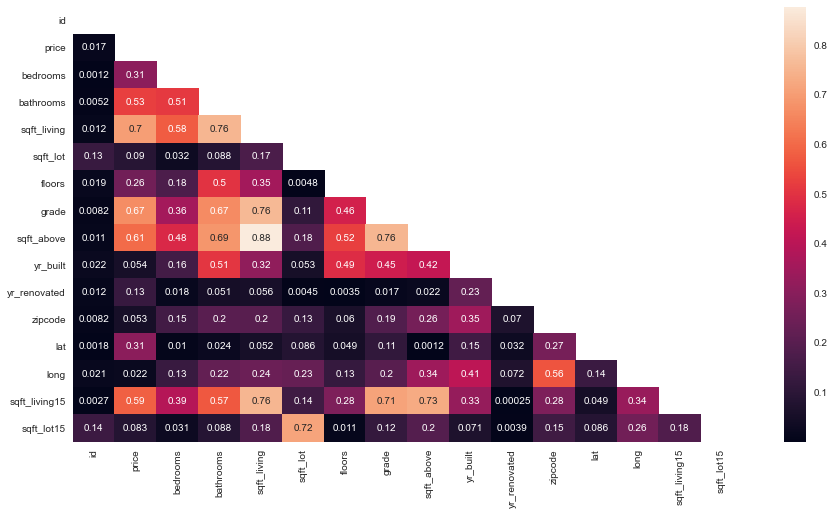

In [11]:
# Here we make up a heat map to see the variables that have the highest
# correlation with price and the variables that have high collinearity
corr = abs(housing_df.corr())
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True);

# We can see that sqft_above is collinear with sqft_living. 
# That's why we can replace sqft_above with boolean for new column 'basement'
# We also see collinearity between sqft_living and grade. square footage is numeric and continuous,
# easier to use than grade. We can drop grade.
# sqft_living is highest correlation to price 

Here we plot the correlation coefficients for all the numerical values. We see that the sqft_living variable has the highest correlation with price. It will be a great option for our first simple linear model. There is a lot of collinearity of different variables, so we will plan on getting rid of a lot of the redundant variables. A lot of information given by grade and sqft_above will probably be better explained by sqft_living, so we'll drop those two variables from the clean data frame.

## Feature Engineering

While knowing when a house was built can be a big factor in the value of the house, we thought that a making a new column that told us the age of the house when it was sold would be more accurate.

In [12]:
# feature engineering
# Created a year_sold column using the .dt to broadcast the .year to the whole column
housing_df['year_sold'] = housing_df['date'].dt.year
# then subtracted yr_built from year_sold to get the age_when_sold column
housing_df['age_when_sold'] = housing_df['year_sold'] - housing_df['yr_built']

Knowing about the exact size of the basement won't be as useful as knowing if the house has a basement at all. We created a new column that will tell us if the house has a basement or not.

In [13]:
# feature engineering 
# first we overwrite the basement formula by substracting sqft_above from sqft_living
housing_df['sqft_basement'] = housing_df['sqft_living'] - housing_df['sqft_above']
# then we use the lamda function to return true for houses where sqft_basement is above 0
housing_df['basement'] = housing_df['sqft_basement'].map(lambda x: True if x > 0 else False)
# finally we turn it into type integer so that we can use the variable ohe style
housing_df['basement'] = housing_df['basement'].astype(int)

In [14]:
# created a numerical df to look at a pair plot of all the numerical values
numerical_df = housing_df[['price','bedrooms','bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'age_when_sold' ]]

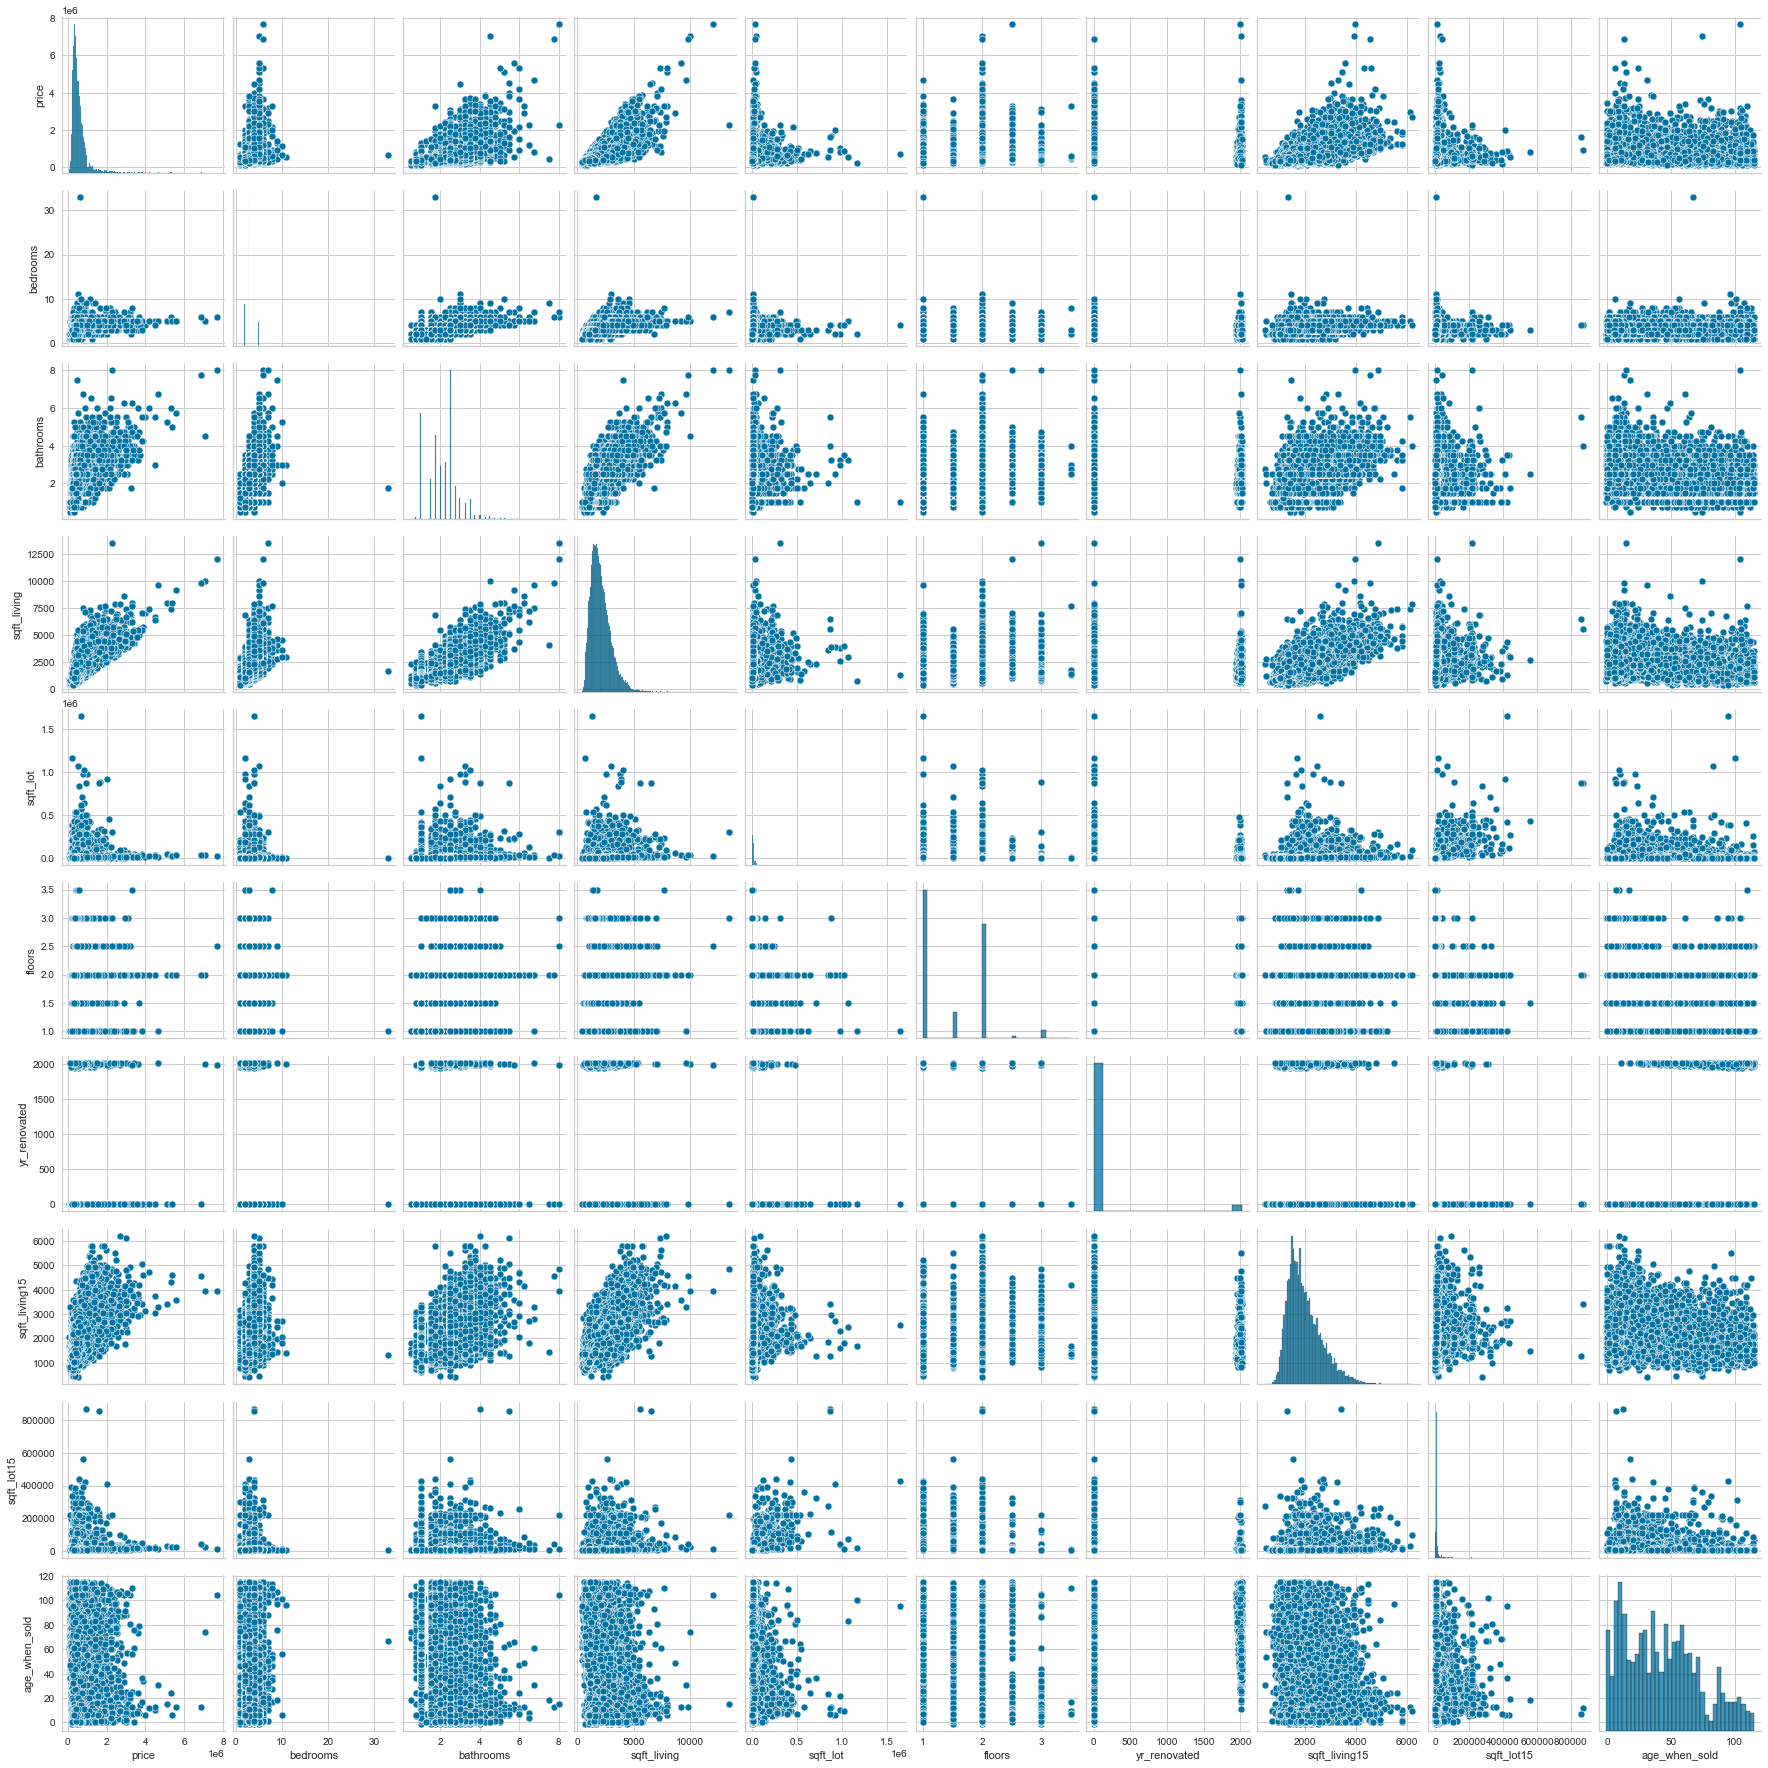

In [15]:
# plotted the pairplot
sns.pairplot(numerical_df);

In [16]:
# dropping numerical values that don't show relationship with price, as well as extraneous columns based on data processing above.
housing_df_clean = housing_df.drop(['id','date', 'sqft_lot15', 'sqft_lot', 'floors', 'grade','sqft_basement','sqft_above','yr_built', 'year_sold', 'yr_renovated', 'lat', 'long', 'age_when_sold'], axis=1)
housing_df_clean

,price,bedrooms,bathrooms,sqft_living,waterfront,view,condition,zipcode,sqft_living15,basement
0,221900.0,3,1.00,1180,NaN,NONE,Average,98178,1340,0
1,538000.0,3,2.25,2570,NO,NONE,Average,98125,1690,1
2,180000.0,2,1.00,770,NO,NONE,Average,98028,2720,0
3,604000.0,4,3.00,1960,NO,NONE,Very Good,98136,1360,1
4,510000.0,3,2.00,1680,NO,NONE,Average,98074,1800,0
...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,NO,NONE,Average,98103,1530,0
21593,400000.0,4,2.50,2310,NO,NONE,Average,98146,1830,0
21594,402101.0,2,0.75,1020,NO,NONE,Average,98144,1020,0
21595,400000.0,3,2.50,1600,NaN,NONE,Average,98027,1410,0


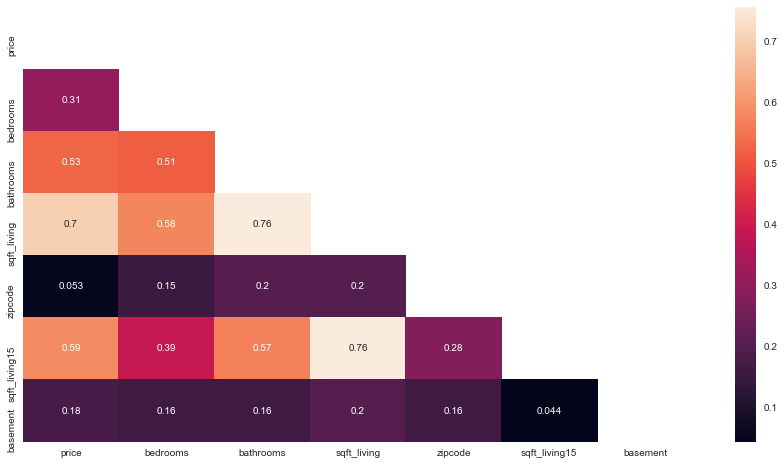

In [17]:
# another heatmap, this time of our new cleaned df
corr = abs(housing_df_clean.corr())
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True);

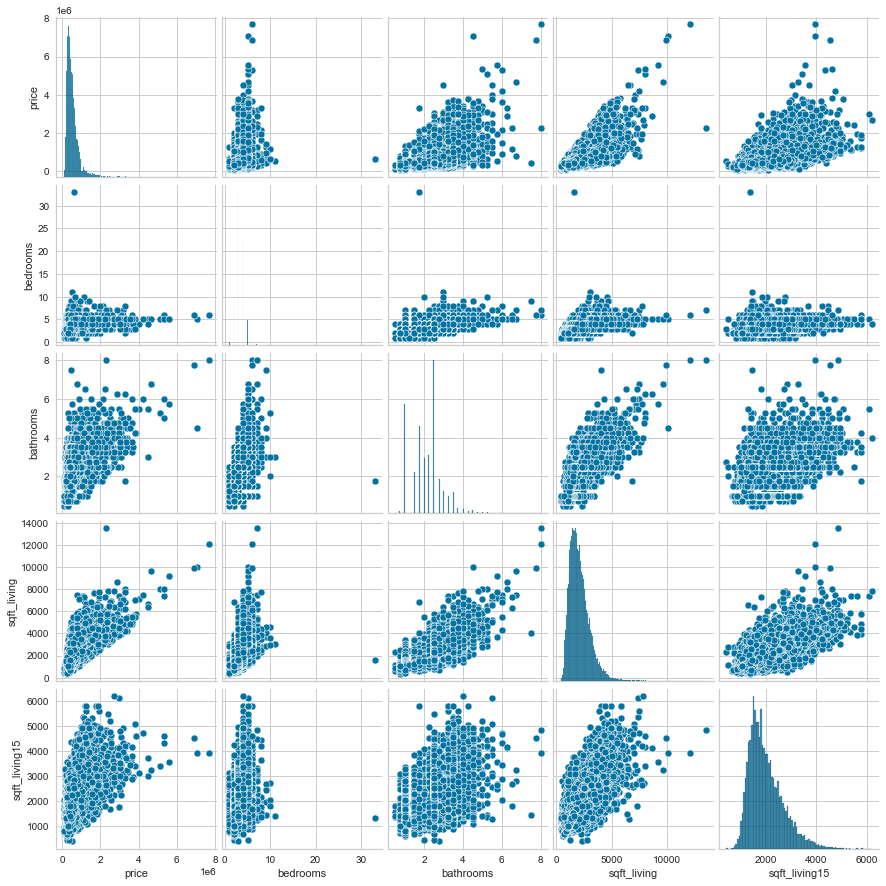

In [18]:
# Here we have a pairplot of all our new numerical data that made the cut
numerical_after_drop_df = housing_df_clean.drop(['waterfront', 'view', 'condition', 'zipcode', 'basement'], axis=1)
sns.pairplot(numerical_after_drop_df);

In [19]:
# start talking about pairplot interpretation here
# we can see how bedrooms has a minimal linear relationship to price. 
# let's keep it in for now, until we run a moedl and find the best coefficients. 

In [20]:
# Here's what the descriptive statistics of our new clean df looks like
housing_df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,zipcode,sqft_living15,basement
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,98077.951845,1986.620318,0.392971
std,3.673681e+05,0.926299,0.768984,918.106125,53.513072,685.230472,0.488422
min,7.800000e+04,1.000000,0.500000,370.000000,98001.000000,399.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,98033.000000,1490.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,98065.000000,1840.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,98118.000000,2360.000000,1.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,98199.000000,6210.000000,1.000000


In [21]:
# Filtering outliers to improve the fit of the model
# Take out the outermost 
housing_df_clean['bathrooms'] = housing_df_clean['bathrooms'][housing_df_clean['bathrooms'].between(housing_df_clean['bathrooms'].quantile(.005), housing_df_clean['bathrooms'].quantile(.995), inclusive=True)]
housing_df_clean['bedrooms'] = housing_df_clean['bedrooms'][housing_df_clean['bedrooms'].between(housing_df_clean['bedrooms'].quantile(.005), housing_df_clean['bedrooms'].quantile(.995), inclusive=True)]
housing_df_clean['sqft_living'] = housing_df_clean['sqft_living'][housing_df_clean['sqft_living'].between(housing_df_clean['sqft_living'].quantile(.005), housing_df_clean['sqft_living'].quantile(.995), inclusive=True)]

In [22]:
housing_df_clean.dropna(inplace=True)

In [23]:
X = housing_df_clean.drop(columns = 'price', axis=1)
y = housing_df_clean['price']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
view_col = X_train[['view']]
imputer_view = SimpleImputer(strategy='constant', fill_value = 'NONE')
imputer_view.fit(view_col)
view_imputed = imputer_view.transform(view_col)
X_train.view = view_imputed

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
view_col = X_test[['view']]
view_imputed = imputer_view.transform(view_col)
X_test.view = view_imputed

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
water_col = X_train[['waterfront']]
imputer_water = SimpleImputer(strategy='constant', fill_value = 'NO')
imputer_water.fit(water_col)
waterfront_imputed = imputer_water.transform(water_col)
X_train.waterfront = waterfront_imputed

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
water_col = X_test[['waterfront']]
waterfront_test_imputed = imputer_water.transform(water_col)
X_test.waterfront = waterfront_test_imputed

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
cat_cols = [ 'waterfront', 'view', 'condition', 'zipcode']
cat_cols

['waterfront', 'view', 'condition', 'zipcode']

In [30]:
X_train.isna().sum()

bedrooms         0
bathrooms        0
sqft_living      0
waterfront       0
view             0
condition        0
zipcode          0
sqft_living15    0
basement         0
dtype: int64

In [31]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [32]:
X_train_enc = pd.DataFrame(X_train_enc.todense(), index=X_train.index, columns= ct.get_feature_names())

In [33]:
X_test_enc = pd.DataFrame(X_test_enc.todense(), index=X_test.index, columns= ct.get_feature_names())

In [34]:
# intstantiate our scaler
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_enc)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [35]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index ,columns= ct.get_feature_names())

In [36]:
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns= ct.get_feature_names())

In [37]:
view_col = X_train[['view']]
encoder_view = OrdinalEncoder(categories=[["NONE","FAIR", "AVERAGE", "GOOD", "EXCELLENT"]])
encoder_view.fit(view_col)
encoded_view = encoder_view.transform(view_col)
encoded_view = encoded_view.flatten()
X_train.view = encoded_view

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
encoder_view.categories_

[array(['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'], dtype=object)]

In [39]:
view_col = X_test[['view']]
encoded_view = encoder_view.transform(view_col)
encoded_view = encoded_view.flatten()
X_test.view = encoded_view

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [40]:
water_col = X_train[['waterfront']]
encoder_water = OrdinalEncoder()
encoder_water.fit(water_col)
encoded_water = encoder_water.transform(water_col)
encoded_water = encoded_water.flatten()
X_train.waterfront = encoded_water

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
water_col = X_test[['waterfront']]
encoded_water = encoder_water.transform(water_col)
encoded_water = encoded_water.flatten()
X_test.waterfront = encoded_water

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
cat_cols_ordinal = ['condition', 'zipcode']
cat_cols_ordinal

['condition', 'zipcode']

In [43]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols_ordinal)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_ord = ct.transform(X_train)
X_test_ord = ct.transform(X_test)

In [44]:
X_train_ord = pd.DataFrame(X_train_ord.todense(), index=X_train.index, columns= ct.get_feature_names())

In [45]:
X_test_ord = pd.DataFrame(X_test_ord.todense(), index=X_test.index, columns= ct.get_feature_names())

In [46]:
# intstantiate our scaler
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_ord)

# transform both train and test data
X_train_scaled_ord = scaler.transform(X_train_ord)
X_test_scaled_ord = scaler.transform(X_test_ord)

In [47]:
X_train_scaled_ord = pd.DataFrame(X_train_scaled_ord, index=X_train.index, columns= ct.get_feature_names())

In [48]:
X_test_scaled_ord = pd.DataFrame(X_test_scaled_ord, index=X_test.index, columns= ct.get_feature_names())

In [49]:
# function to generate error 
def res_plots(model, X_train, X_test, y_train, y_test):
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_resids = y_train - train_preds
    test_resids = y_test - test_preds
    
    durbinWatson = durbin_watson(test_resids)
    
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    test_rmse = mean_squared_error(y_test, test_preds, squared=False)
    
    bins = int(  len(X_test)**.5 )
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9, 18), nrows=3)
    sns.histplot(test_resids, bins=bins, kde=True, ax=ax1)
    sm.qqplot(test_resids, line='r', ax=ax2)
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    
    plt.show()
    print(f'R2_train: {r2_score(y_train, train_preds):.3f}'),\
    print(f'R2_test: {r2_score(y_test, test_preds):.3f}'),\
    print(f'Durbin-Watson: {durbinWatson:.3f}'),\
    print(f'Train Mean Squarred Error: {train_mse:.3f}'),\
    print(f'Test Mean Squarred Error: {test_mse:.3f}'),\
    print(f'Test RMSE: {test_rmse:.3f}')
    

In [50]:
def res_plots_log(model, X_train, X_test, y_train, y_test):
    
    train_preds = np.exp(model.predict(X_train))
    test_preds = np.exp(model.predict(X_test))
    train_resids = np.exp(y_train) - train_preds
    test_resids = np.exp(y_test) - test_preds
    
    durbinWatson = durbin_watson(test_resids)
    
    train_mse = mean_squared_error(np.exp(y_train), train_preds)
    test_mse = mean_squared_error(np.exp(y_test), test_preds)
    test_rmse = mean_squared_error(np.exp(y_test), test_preds, squared=False)
    
    bins = int(  len(X_test)**.5 )
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9, 18), nrows=3)
    sns.histplot(test_resids, bins=bins, kde=True, ax=ax1)
    sm.qqplot(test_resids, line='r', ax=ax2)
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    
    plt.show()
    print(f'R2_train: {r2_score(y_train, np.log(train_preds)):.3f}'),\
    print(f'R2_test: {r2_score(y_test, np.log(test_preds)):.3f}'),\
    print(f'Durbin-Watson: {durbinWatson:.3f}'),\
    print(f'Train Mean Squarred Error: {train_mse:.3f}'),\
    print(f'Test Mean Squarred Error: {test_mse:.3f}'),\
    print(f'Test RMSE: {test_rmse:.3f}')

In [51]:
# Setting up our dummy regressor
dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)
print(dummy_regr.score(X_train, y_train))
print(dummy_regr.score(X_test, y_test))

0.0
-0.00011378091138736224


In [52]:
# first simple model

col_use = ['sqft_living']
fsm_model = LinearRegression()
fsm_model.fit(X_train_scaled[col_use], y_train)
print(fsm_model.score(X_train_scaled[col_use], y_train))
print(fsm_model.score(X_test_scaled[col_use], y_test))

0.4434770783789924
0.45638311722154457


In [53]:
fsm_model_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled[col_use]))
fsm_model_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.006e+04
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:20:37   Log-Likelihood:            -1.7429e+05
No. Observations:               12628   AIC:                         3.486e+05
Df Residuals:                   12626   BIC:                         3.486e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.298e+05   2124.396    249.392      0.000    5.26e+05    5.34e+05
sqft_living  2.131e+05   2124.396    100.306      0.000    2.09e+05    2.17e+05
==============================================================================
Omnibus:                     6363.203   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78315.138
Skew:                           2.126   Prob(JB):                         0.00
Kurtosis:                      14.435   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

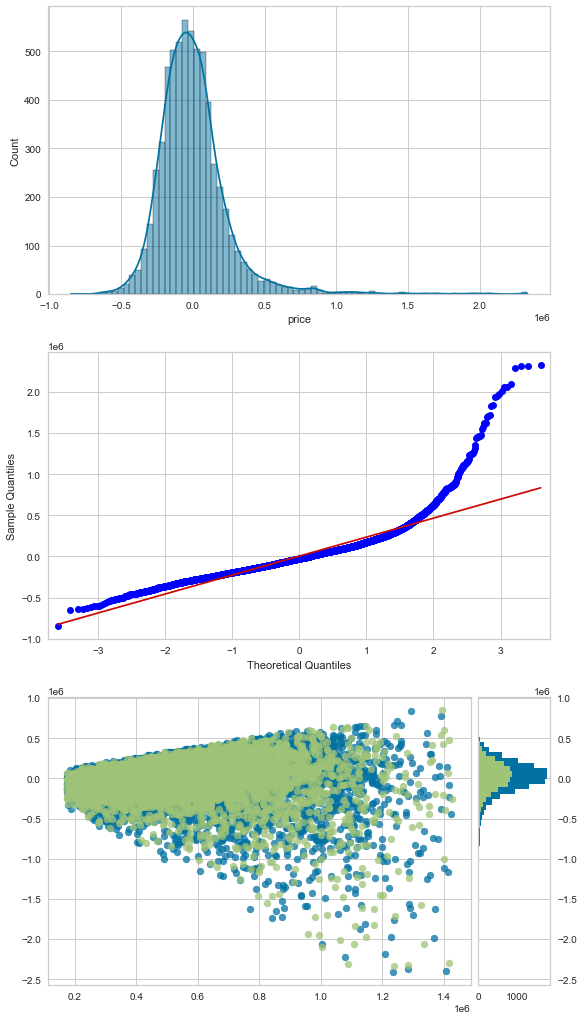

R2_train: 0.443
R2_test: 0.456
Durbin-Watson: 1.994
Train Mean Squarred Error: 56981895498.752
Test Mean Squarred Error: 63612524980.058
Test RMSE: 252215.235


In [54]:
res_plots(fsm_model, X_train_scaled[col_use], X_test_scaled[col_use], y_train, y_test)

In [55]:
# model with no encoders
col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement']
mlr_1 = LinearRegression()
mlr_1.fit(X_train_scaled[col_use], y_train)
print(mlr_1.score(X_train_scaled[col_use], y_train))
print(mlr_1.score(X_test_scaled[col_use], y_test))

0.47692684780350747
0.4832364290167689


In [56]:
mlr_1_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled[col_use]))
mlr_1_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     2302.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:20:47   Log-Likelihood:            -1.7390e+05
No. Observations:               12628   AIC:                         3.478e+05
Df Residuals:                   12622   BIC:                         3.479e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.298e+05   2059.890    257.202      0.000    5.26e+05    5.34e+05
sqft_living    1.848e+05   4197.712     44.026      0.000    1.77e+05    1.93e+05
bedrooms      -4.634e+04   2576.804    -17.982      0.000   -5.14e+04   -4.13e+04
bathrooms      6274.4983   3064.793      2.047      0.041     267.038    1.23e+04
sqft_living15  6.146e+04   3212.188     19.134      0.000    5.52e+04    6.78e+04
basement       2.458e+04   2134.709     11.513      0.000    2.04e+04    2.88e+04
==============================================================================
Omnibus:                     6345.267   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78320.452
Skew:                           2.117   Prob(JB):                         0.00
Kurtosis:                      14.442   Cond. No.                         4.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

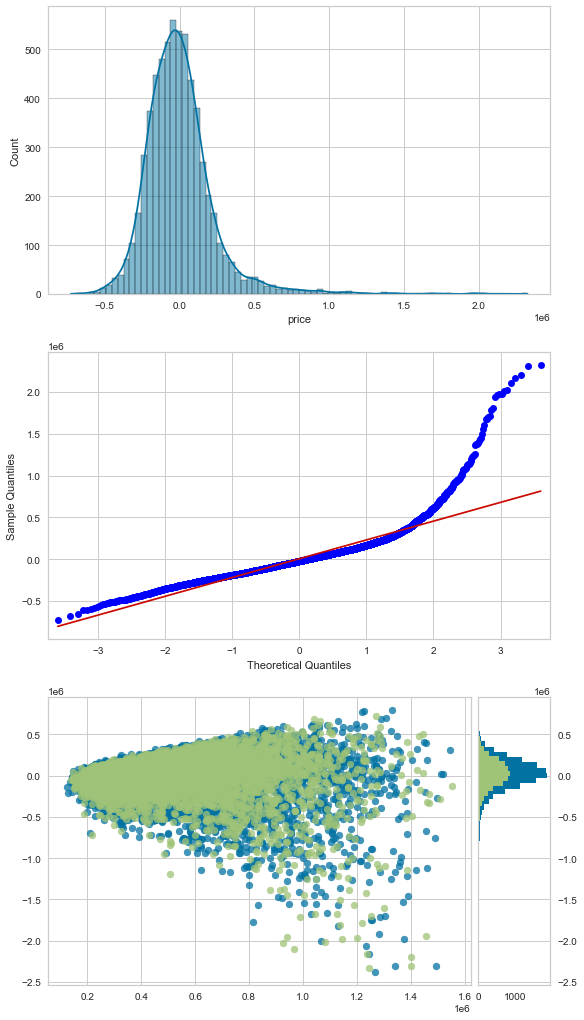

R2_train: 0.477
R2_test: 0.483
Durbin-Watson: 1.993
Train Mean Squarred Error: 53557002845.179
Test Mean Squarred Error: 60470225648.514
Test RMSE: 245906.945


In [57]:
res_plots(mlr_1, X_train_scaled[col_use], X_test_scaled[col_use], y_train, y_test)

In [58]:
#model with no encoders and log of price 
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement',]
mlr_2 = LinearRegression()
mlr_2.fit(X_train_scaled[col_use], y_train_log)
print(mlr_2.score(X_train_scaled[col_use], y_train_log))
print(mlr_2.score(X_test_scaled[col_use], y_test_log))

0.4902486235018725
0.5083867534987281


In [59]:
mlr_2_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled[col_use]))
mlr_2_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     2428.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:20:54   Log-Likelihood:                -5083.9
No. Observations:               12628   AIC:                         1.018e+04
Df Residuals:                   12622   BIC:                         1.022e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0439      0.003   4049.176      0.000      13.038      13.050
sqft_living       0.2483      0.007     37.822      0.000       0.235       0.261
bedrooms         -0.0583      0.004    -14.461      0.000      -0.066      -0.050
bathrooms         0.0377      0.005      7.863      0.000       0.028       0.047
sqft_living15     0.1180      0.005     23.484      0.000       0.108       0.128
basement          0.0523      0.003     15.680      0.000       0.046       0.059
==============================================================================
Omnibus:                       28.195   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.582
Skew:                           0.056   Prob(JB):                     4.59e-06
Kurtosis:                       2.816   Cond. No.                         4.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

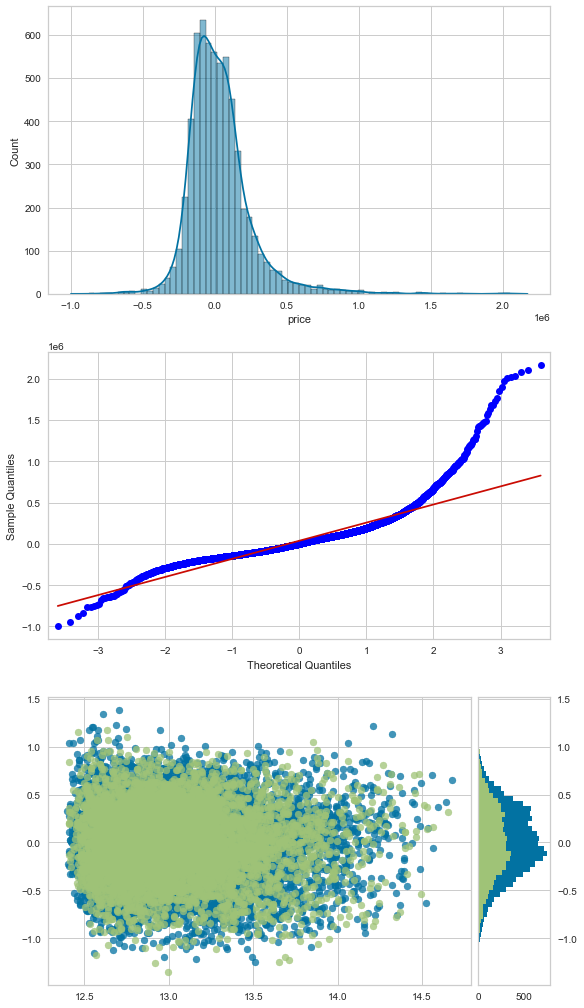

R2_train: 0.490
R2_test: 0.508
Durbin-Watson: 1.958
Train Mean Squarred Error: 52117935188.968
Test Mean Squarred Error: 59270964872.111
Test RMSE: 243456.289


In [60]:
res_plots_log(mlr_2, X_train_scaled[col_use], X_test_scaled[col_use], y_train_log, y_test_log)

In [61]:
# model with just waterfront and view ordinal encoder 
col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement','view', 'waterfront']
mlr_3 = LinearRegression()
mlr_3.fit(X_train_scaled_ord[col_use], y_train)
print(mlr_3.score(X_train_scaled_ord[col_use], y_train))
print(mlr_3.score(X_test_scaled_ord[col_use], y_test))

0.5283430634944137
0.5365945488050086


In [62]:
mlr_3_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled_ord[col_use]))
mlr_3_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     2020.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:20:57   Log-Likelihood:            -1.7325e+05
No. Observations:               12628   AIC:                         3.465e+05
Df Residuals:                   12620   BIC:                         3.466e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.298e+05   1956.187    270.837      0.000    5.26e+05    5.34e+05
sqft_living    1.704e+05   4006.603     42.519      0.000    1.63e+05    1.78e+05
bedrooms      -3.716e+04   2459.624    -15.109      0.000    -4.2e+04   -3.23e+04
bathrooms      7546.3961   2911.440      2.592      0.010    1839.531    1.33e+04
sqft_living15  5.221e+04   3073.969     16.984      0.000    4.62e+04    5.82e+04
basement       1.638e+04   2052.366      7.979      0.000    1.24e+04    2.04e+04
view           4.988e+04   2237.219     22.298      0.000    4.55e+04    5.43e+04
waterfront     4.023e+04   2132.448     18.864      0.000     3.6e+04    4.44e+04
==============================================================================
Omnibus:                     5336.631   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53258.549
Skew:                           1.759   Prob(JB):                         0.00
Kurtosis:                      12.426   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

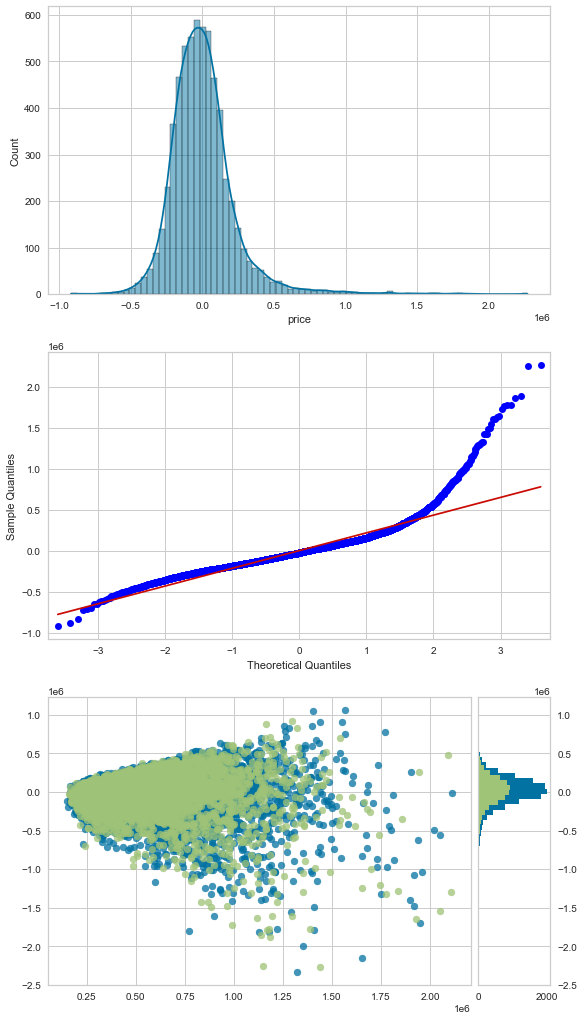

R2_train: 0.528
R2_test: 0.537
Durbin-Watson: 1.992
Train Mean Squarred Error: 48292541462.516
Test Mean Squarred Error: 54226407924.218
Test RMSE: 232865.644


In [63]:
res_plots(mlr_3, X_train_scaled_ord[col_use], X_test_scaled_ord[col_use], y_train, y_test)

In [64]:
# model with ohe 
col_use = X_train_scaled
mlr_4 = LinearRegression()
mlr_4.fit(X_train_scaled, y_train)
print(mlr_4.score(X_train_scaled, y_train))
print(mlr_4.score(X_test_scaled, y_test))

0.7989391378055755
0.7990134323617074


In [65]:
mlr_4_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled))
mlr_4_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     600.5
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:21:02   Log-Likelihood:            -1.6786e+05
No. Observations:               12628   AIC:                         3.359e+05
Df Residuals:                   12544   BIC:                         3.365e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.298e+05   1281.069    413.567      0.000    5.27e+05    5.32e+05
ohe__x0_YES        4.117e+04   1613.169     25.520      0.000     3.8e+04    4.43e+04
ohe__x1_EXCELLENT  3.019e+04   1737.438     17.377      0.000    2.68e+04    3.36e+04
ohe__x1_FAIR       2482.8729   1475.158      1.683      0.092    -408.663    5374.408
ohe__x1_GOOD       1.463e+04   1556.351      9.399      0.000    1.16e+04    1.77e+04
ohe__x1_NONE      -2.199e+04   1899.908    -11.576      0.000   -2.57e+04   -1.83e+04
ohe__x2_Fair       1008.6049   1293.606      0.780      0.436   -1527.060    3544.270
ohe__x2_Good       8665.3627   1394.197      6.215      0.000    5932.523    1.14e+04
ohe__x2_Poor      -3885.9563   1289.156     -3.014      0.003   -6412.900   -1359.013
ohe__x2_Very Good  1.648e+04   1343.080     12.269      0.000    1.38e+04    1.91e+04
ohe__x3_98002      2161.4505   1579.013      1.369      0.171    -933.657    5256.558
ohe__x3_98003      1334.3568   1688.731      0.790      0.429   -1975.815    4644.529
ohe__x3_98004      9.242e+04   1708.694     54.086      0.000    8.91e+04    9.58e+04
ohe__x3_98005      3.282e+04   1577.265     20.810      0.000    2.97e+04    3.59e+04
ohe__x3_98006      4.383e+04   1892.471     23.161      0.000    4.01e+04    4.75e+04
ohe__x3_98007      2.125e+04   1473.207     14.424      0.000    1.84e+04    2.41e+04
ohe__x3_98008      3.218e+04   1700.017     18.926      0.000    2.88e+04    3.55e+04
ohe__x3_98010      3971.6406   1430.277      2.777      0.005    1168.079    6775.202
ohe__x3_98011      1.323e+04   1598.304      8.278      0.000    1.01e+04    1.64e+04
ohe__x3_98014      7272.4652   1455.215      4.998      0.000    4420.020    1.01e+04
ohe__x3_98019      8242.7405   1579.254      5.219      0.000    5147.161    1.13e+04
ohe__x3_98022       140.4927   1609.499      0.087      0.930   -3014.372    3295.357
ohe__x3_98023     -2562.8607   1944.726     -1.318      0.188   -6374.822    1249.101
ohe__x3_98024       1.12e+04   1426.175      7.855      0.000    8407.057     1.4e+04
ohe__x3_98027      2.407e+04   1803.420     13.349      0.000    2.05e+04    2.76e+04
ohe__x3_98028      1.432e+04   1670.200      8.575      0.000     1.1e+04    1.76e+04
ohe__x3_98029      2.861e+04   1748.412     16.362      0.000    2.52e+04     3.2e+04
ohe__x3_98030       171.5558   1678.330      0.102      0.919   -3118.227    3461.339
ohe__x3_98031      2206.1217   1642.853      1.343      0.179   -1014.122    5426.366
ohe__x3_98032      1073.2551   1487.239      0.722      0.471   -1841.961    3988.471
ohe__x3_98033      5.335e+04   1857.312     28.725      0.000    4.97e+04     5.7e+04
ohe__x3_98034      3.559e+04   1967.240     18.091      0.000    3.17e+04    3.94e+04
ohe__x3_98038      3585.8360   2017.321      1.778      0.076    -368.422

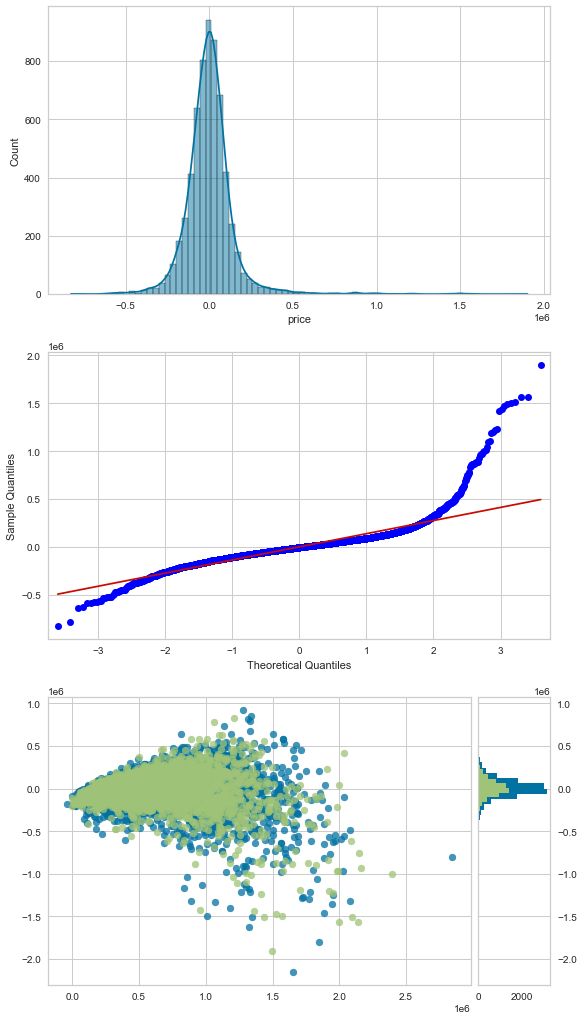

R2_train: 0.799
R2_test: 0.799
Durbin-Watson: 1.968
Train Mean Squarred Error: 20586445936.640
Test Mean Squarred Error: 23518885192.088
Test RMSE: 153358.682


In [66]:
res_plots(mlr_4, X_train_scaled, X_test_scaled, y_train, y_test)

In [67]:
# model with ohe and ordinal encoders 
col_use = X_train_scaled_ord
mlr_5 = LinearRegression()
mlr_5.fit(X_train_scaled_ord, y_train)
print(mlr_5.score(X_train_scaled_ord, y_train))
print(mlr_5.score(X_test_scaled_ord, y_test))

0.7971429232698508
0.7979105823817793


In [68]:
mlr_5_ols = sm.OLS(y_train, sm.add_constant(X_train_scaled_ord))
mlr_5_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     616.3
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:21:06   Log-Likelihood:            -1.6792e+05
No. Observations:               12628   AIC:                         3.360e+05
Df Residuals:                   12547   BIC:                         3.366e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.298e+05   1286.625    411.781      0.000    5.27e+05    5.32e+05
ohe__x0_Fair        951.3184   1299.203      0.732      0.464   -1595.318    3497.955
ohe__x0_Good       8898.9664   1400.032      6.356      0.000    6154.689    1.16e+04
ohe__x0_Poor      -3849.1683   1294.712     -2.973      0.003   -6387.002   -1311.335
ohe__x0_Very Good  1.672e+04   1347.720     12.406      0.000    1.41e+04    1.94e+04
ohe__x1_98002      2181.7946   1585.836      1.376      0.169    -926.686    5290.275
ohe__x1_98003      1177.5184   1695.670      0.694      0.487   -2146.255    4501.292
ohe__x1_98004       9.26e+04   1714.677     54.006      0.000    8.92e+04     9.6e+04
ohe__x1_98005      3.292e+04   1583.977     20.783      0.000    2.98e+04     3.6e+04
ohe__x1_98006      4.378e+04   1900.652     23.037      0.000    4.01e+04    4.75e+04
ohe__x1_98007      2.118e+04   1479.577     14.312      0.000    1.83e+04    2.41e+04
ohe__x1_98008      3.222e+04   1707.115     18.877      0.000    2.89e+04    3.56e+04
ohe__x1_98010      3936.1603   1436.381      2.740      0.006    1120.634    6751.686
ohe__x1_98011      1.331e+04   1605.176      8.292      0.000    1.02e+04    1.65e+04
ohe__x1_98014      7059.2378   1461.365      4.831      0.000    4194.739    9923.736
ohe__x1_98019      8249.3026   1586.099      5.201      0.000    5140.305    1.14e+04
ohe__x1_98022      -486.8680   1615.292     -0.301      0.763   -3653.088    2679.352
ohe__x1_98023     -2535.3805   1953.047     -1.298      0.194   -6363.652    1292.891
ohe__x1_98024      1.102e+04   1432.246      7.691      0.000    8207.969    1.38e+04
ohe__x1_98027      2.403e+04   1811.226     13.267      0.000    2.05e+04    2.76e+04
ohe__x1_98028       1.44e+04   1677.403      8.584      0.000    1.11e+04    1.77e+04
ohe__x1_98029      2.848e+04   1755.949     16.219      0.000     2.5e+04    3.19e+04
ohe__x1_98030       183.4002   1685.606      0.109      0.913   -3120.645    3487.446
ohe__x1_98031      2205.0723   1649.976      1.336      0.181   -1029.133    5439.278
ohe__x1_98032      1105.0195   1493.669      0.740      0.459   -1822.800    4032.839
ohe__x1_98033      5.328e+04   1864.915     28.569      0.000    4.96e+04    5.69e+04
ohe__x1_98034      3.563e+04   1975.623     18.032      0.000    3.18e+04    3.95e+04
ohe__x1_98038      3654.0112   2026.045      1.804      0.071    -317.348    7625.370
ohe__x1_98039      4.619e+04   1362.681     33.893      0.000    4.35e+04    4.89e+04
ohe__x1_98040      5.692e+04   1673.617     34.010      0.000    5.36e+04    6.02e+04
ohe__x1_98042       162.6875   1989.443      0.082      0.935   -3736.925    4062.300
ohe__x1_98045      1.068e+04   1627.139      6.564      0.000    7491.455    1.39e+04
ohe__x1_98052      4.188e+04   2027.869     20.650      0.000    3.79e+04

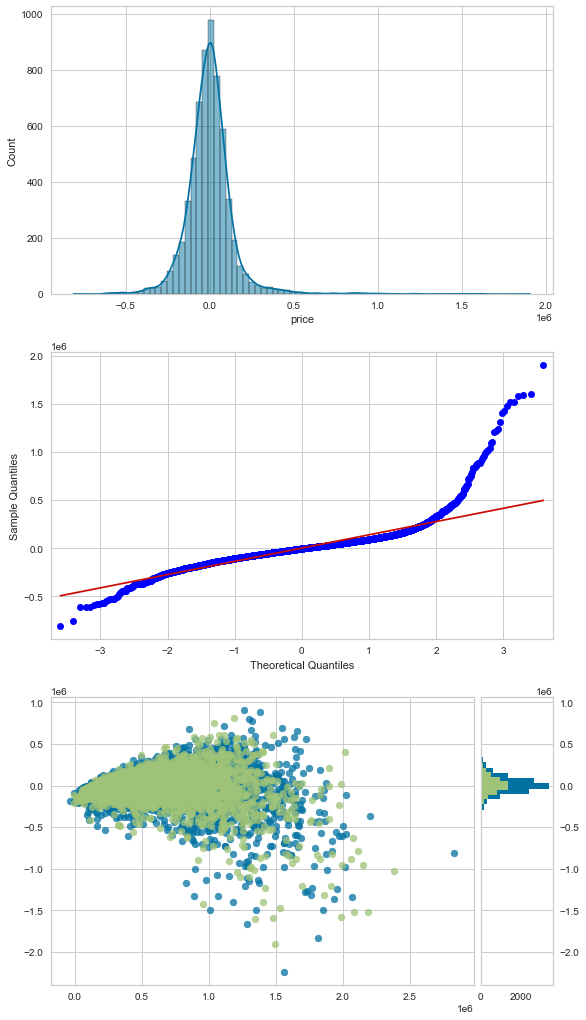

R2_train: 0.797
R2_test: 0.798
Durbin-Watson: 1.964
Train Mean Squarred Error: 20770358772.916
Test Mean Squarred Error: 23647937607.713
Test RMSE: 153778.859


In [69]:
res_plots(mlr_5, X_train_scaled_ord, X_test_scaled_ord, y_train, y_test)

In [70]:
# model with ohe and ordinal encoders and log price, before RFE

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord
mlr_6 = LinearRegression()
mlr_6.fit(X_train_scaled_ord, y_train_log)
print(mlr_6.score(X_train_scaled_ord, y_train_log))
print(mlr_6.score(X_test_scaled_ord, y_test_log))

0.8562404255986689
0.8607408497187228


In [71]:
mlr_6_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord))
mlr_6_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     934.1
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:21:09   Log-Likelihood:                 2908.2
No. Observations:               12628   AIC:                            -5654.
Df Residuals:                   12547   BIC:                            -5051.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.0439      0.002   7602.096      0.000      13.041      13.047
ohe__x0_Fair         -0.0081      0.002     -4.698      0.000      -0.012      -0.005
ohe__x0_Good          0.0175      0.002      9.385      0.000       0.014       0.021
ohe__x0_Poor         -0.0122      0.002     -7.072      0.000      -0.016      -0.009
ohe__x0_Very Good     0.0246      0.002     13.672      0.000       0.021       0.028
ohe__x1_98002        -0.0032      0.002     -1.505      0.132      -0.007       0.001
ohe__x1_98003         0.0044      0.002      1.947      0.052   -3.06e-05       0.009
ohe__x1_98004         0.1328      0.002     58.088      0.000       0.128       0.137
ohe__x1_98005         0.0741      0.002     35.067      0.000       0.070       0.078
ohe__x1_98006         0.0949      0.003     37.448      0.000       0.090       0.100
ohe__x1_98007         0.0530      0.002     26.885      0.000       0.049       0.057
ohe__x1_98008         0.0798      0.002     35.031      0.000       0.075       0.084
ohe__x1_98010         0.0160      0.002      8.372      0.000       0.012       0.020
ohe__x1_98011         0.0458      0.002     21.400      0.000       0.042       0.050
ohe__x1_98014         0.0264      0.002     13.535      0.000       0.023       0.030
ohe__x1_98019         0.0340      0.002     16.077      0.000       0.030       0.038
ohe__x1_98022         0.0082      0.002      3.787      0.000       0.004       0.012
ohe__x1_98023        -0.0011      0.003     -0.406      0.685      -0.006       0.004
ohe__x1_98024         0.0310      0.002     16.219      0.000       0.027       0.035
ohe__x1_98027         0.0686      0.002     28.413      0.000       0.064       0.073
ohe__x1_98028         0.0476      0.002     21.285      0.000       0.043       0.052
ohe__x1_98029         0.0780      0.002     33.326      0.000       0.073       0.083
ohe__x1_98030         0.0062      0.002      2.773      0.006       0.002       0.011
ohe__x1_98031         0.0098      0.002      4.442      0.000       0.005       0.014
ohe__x1_98032        -0.0017      0.002     -0.849      0.396      -0.006       0.002
ohe__x1_98033         0.1131      0.002     45.459      0.000       0.108       0.118
ohe__x1_98034         0.0894      0.003     33.945      0.000       0.084       0.095
ohe__x1_98038         0.0273      0.003     10.089      0.000       0.022       0.033
ohe__x1_98039         0.0563      0.002     30.967      0.000       0.053       0.060
ohe__x1_98040         0.0969      0.002     43.410      0.000       0.093       0.101
ohe__x1_98042         0.0111      0.003      4.167      0.000       0.006       0.016
ohe__x1_98045         0.0375      0.002     17.302      0.000       0.033       0.042
ohe__x1_98052         0.1090      0.003     40.314      0.000       0.104

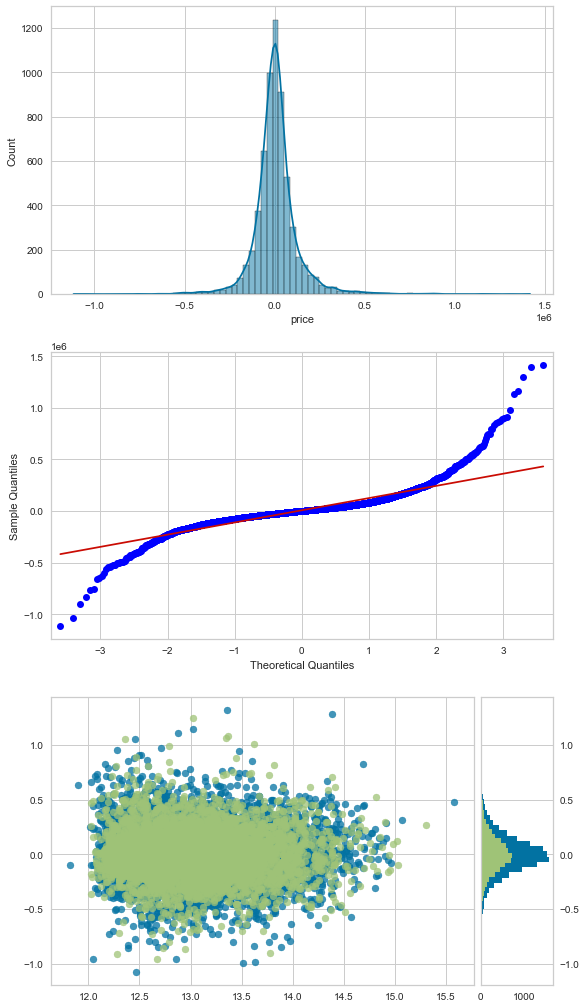

R2_train: 0.856
R2_test: 0.861
Durbin-Watson: 1.996
Train Mean Squarred Error: 16438933468.790
Test Mean Squarred Error: 16875160703.349
Test RMSE: 129904.429


In [72]:
res_plots_log(mlr_6, X_train_scaled_ord, X_test_scaled_ord, y_train_log, y_test_log)

In [73]:
# Make a new model to explore how each feature impacts the model
mlr_6_rfe = LinearRegression()

# Instantiate our RFE with that new model and how many features we want, first cutting features in half
rfe = RFE(mlr_6_rfe, n_features_to_select=40)

# Fit to our polynomial training data
rfe.fit(X_train_scaled_ord, y_train_log)

RFE(estimator=LinearRegression(), n_features_to_select=40)

In [74]:
rfe_selectors = []

for col_name, support in dict(zip(X_train_scaled_ord.columns, rfe.support_)).items():
    if support == True:
        rfe_selectors.append(col_name)


In [75]:
# model with ohe and ordinal encoders and log price, but with top half of variables through RFE

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord[rfe_selectors]
mlr_7 = LinearRegression()
mlr_7.fit(X_train_scaled_ord[rfe_selectors], y_train_log)
print(mlr_7.score(X_train_scaled_ord[rfe_selectors], y_train_log))
print(mlr_7.score(X_test_scaled_ord[rfe_selectors], y_test_log))

0.809432792927224
0.8239440679058158


In [76]:
mlr_7_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord[rfe_selectors]))
mlr_7_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1337.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:21:15   Log-Likelihood:                 1128.5
No. Observations:               12628   AIC:                            -2175.
Df Residuals:                   12587   BIC:                            -1870.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0439      0.002   6613.309      0.000      13.040      13.048
ohe__x1_98004     0.1078      0.002     53.563      0.000       0.104       0.112
ohe__x1_98005     0.0549      0.002     27.494      0.000       0.051       0.059
ohe__x1_98006     0.0653      0.002     32.063      0.000       0.061       0.069
ohe__x1_98007     0.0383      0.002     19.325      0.000       0.034       0.042
ohe__x1_98008     0.0562      0.002     28.229      0.000       0.052       0.060
ohe__x1_98027     0.0417      0.002     20.797      0.000       0.038       0.046
ohe__x1_98029     0.0551      0.002     27.573      0.000       0.051       0.059
ohe__x1_98033     0.0850      0.002     42.415      0.000       0.081       0.089
ohe__x1_98034     0.0582      0.002     29.068      0.000       0.054       0.062
ohe__x1_98039     0.0465      0.002     23.464      0.000       0.043       0.050
ohe__x1_98040     0.0745      0.002     36.933      0.000       0.071       0.078
ohe__x1_98052     0.0759      0.002     37.581      0.000       0.072       0.080
ohe__x1_98053     0.0545      0.002     27.000      0.000       0.051       0.059
ohe__x1_98072     0.0339      0.002     16.965      0.000       0.030       0.038
ohe__x1_98074     0.0541      0.002     26.765      0.000       0.050       0.058
ohe__x1_98075     0.0471      0.002     22.946      0.000       0.043       0.051
ohe__x1_98102     0.0546      0.002     27.609      0.000       0.051       0.059
ohe__x1_98103     0.1070      0.002     52.953      0.000       0.103       0.111
ohe__x1_98105     0.0815      0.002     41.013      0.000       0.078       0.085
ohe__x1_98107     0.0742      0.002     37.197      0.000       0.070       0.078
ohe__x1_98109     0.0564      0.002     28.512      0.000       0.053       0.060
ohe__x1_98112     0.0956      0.002     47.959      0.000       0.092       0.099
ohe__x1_98115     0.1039      0.002     51.646      0.000       0.100       0.108
ohe__x1_98116     0.0734      0.002     36.550      0.000       0.069       0.077
ohe__x1_98117     0.0996      0.002     49.407      0.000       0.096       0.104
ohe__x1_98118     0.0392      0.002     19.491      0.000       0.035       0.043
ohe__x1_98119     0.0785      0.002     39.497      0.000       0.075       0.082
ohe__x1_98122     0.0737      0.002     37.010      0.000       0.070       0.078
ohe__x1_98125     0.0486      0.002     24.305      0.000       0.045       0.053
ohe__x1_98126     0.0453      0.002     22.587      0.000       0.041       0.049
ohe__x1_98133     0.0414      0.002     20.622      0.000       0.037       0.045
ohe__x1_98136     0.0559      0.002     27.959      0.000       0.052       0.060
ohe__x1_98144     0.0583      0.002     29.200      0.000       0.054       0.062
ohe__x1_98155     0.0355      0.002     17.712   

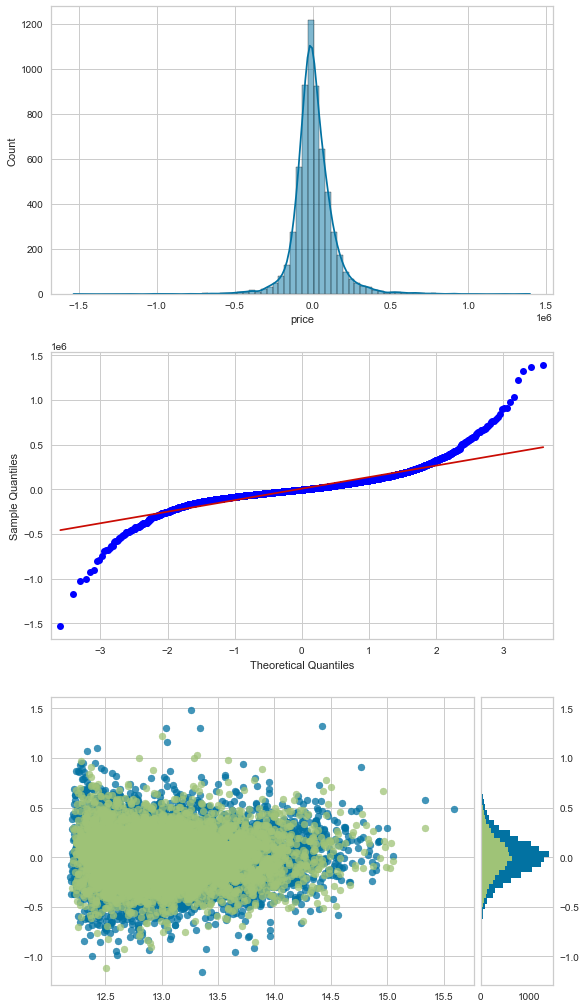

R2_train: 0.809
R2_test: 0.824
Durbin-Watson: 1.986
Train Mean Squarred Error: 19415972942.370
Test Mean Squarred Error: 19663344862.303
Test RMSE: 140226.049


In [77]:
res_plots_log(mlr_7, X_train_scaled_ord[rfe_selectors], X_test_scaled_ord[rfe_selectors], y_train_log, y_test_log)

In [78]:
# Make a new model to explore how each feature impacts the model
mlr_7_rfe = LinearRegression()

# Instantiate our RFE with that new model and how many features we want but we found top 10 
rfe = RFE(mlr_7_rfe, n_features_to_select=10)

# Fit to our polynomial training data
rfe.fit(X_train_scaled_ord, y_train_log)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [79]:
rfe_selectors = []

for col_name, support in dict(zip(X_train_scaled_ord.columns, rfe.support_)).items():
    if support == True:
        rfe_selectors.append(col_name)


In [80]:
# model with ohe and ordinal encoders and log price, but with top 10 through RFE

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord[rfe_selectors]
mlr_8 = LinearRegression()
mlr_8.fit(X_train_scaled_ord[rfe_selectors], y_train_log)
print(mlr_8.score(X_train_scaled_ord[rfe_selectors], y_train_log))
print(mlr_8.score(X_test_scaled_ord[rfe_selectors], y_test_log))

0.6040480879284353
0.6219132184155585


In [81]:
mlr_8_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord[rfe_selectors]))
mlr_8_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     1925.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:21:24   Log-Likelihood:                -3488.8
No. Observations:               12628   AIC:                             7000.
Df Residuals:                   12617   BIC:                             7082.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0439      0.003   4593.446      0.000      13.038      13.050
ohe__x1_98004     0.0782      0.003     27.299      0.000       0.073       0.084
ohe__x1_98103     0.0726      0.003     25.324      0.000       0.067       0.078
ohe__x1_98105     0.0573      0.003     20.164      0.000       0.052       0.063
ohe__x1_98112     0.0697      0.003     24.499      0.000       0.064       0.075
ohe__x1_98115     0.0686      0.003     24.023      0.000       0.063       0.074
ohe__x1_98117     0.0666      0.003     23.268      0.000       0.061       0.072
ohe__x1_98119     0.0561      0.003     19.739      0.000       0.051       0.062
sqft_living       0.2378      0.004     54.616      0.000       0.229       0.246
view              0.0791      0.003     26.722      0.000       0.073       0.085
sqft_living15     0.1136      0.004     25.786      0.000       0.105       0.122
==============================================================================
Omnibus:                        4.402   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.371
Skew:                          -0.044   Prob(JB):                        0.112
Kurtosis:                       3.024   Cond. No.                         2.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
# R2 value significantly lower, this is why we want to include all the zipcodes. 

In [83]:
col_use = ['sqft_living','bedrooms','bathrooms','sqft_living15', 'basement','view', 'waterfront']
mlr_8_rfe = LinearRegression()

rfe = RFE(mlr_8_rfe, n_features_to_select=5)

rfe.fit(X_train_scaled_ord[col_use], y_train)

RFE(estimator=LinearRegression(), n_features_to_select=5)

In [84]:
rfe_selectors = []

for col_name, support in dict(zip(X_train_scaled_ord[col_use].columns, rfe.support_)).items():
    if support == True:
        rfe_selectors.append(col_name)
rfe_selectors

['sqft_living', 'bedrooms', 'sqft_living15', 'view', 'waterfront']

In [85]:
# this tells us to drop bathrooms and basement 
# notice how in the sns plot above, bedrooms were the least linear. makes sense to drop it. 

In [86]:
X_train_scaled_ord = X_train_scaled_ord.drop(columns= ['bedrooms','basement'])
X_test_scaled_ord = X_test_scaled_ord.drop(columns= ['bedrooms','basement'])

In [87]:
# model with ohe and ordinal encoders and log price, all the zipcodes,
# and with dropped numerical 'bedrooms' and 'basement' columns through RFE 

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

col_use = X_train_scaled_ord
mlr_9 = LinearRegression()
mlr_9.fit(X_train_scaled_ord, y_train_log)
print(mlr_9.score(X_train_scaled_ord, y_train_log))
print(mlr_9.score(X_test_scaled_ord, y_test_log))

0.8542525457886809
0.8591964810421127


In [88]:
mlr_9_ols = sm.OLS(y_train_log, sm.add_constant(X_train_scaled_ord))
mlr_9_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     943.0
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:21:27   Log-Likelihood:                 2821.5
No. Observations:               12628   AIC:                            -5485.
Df Residuals:                   12549   BIC:                            -4897.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.0439      0.002   7550.676      0.000      13.041      13.047
ohe__x0_Fair         -0.0086      0.002     -4.917      0.000      -0.012      -0.005
ohe__x0_Good          0.0143      0.002      7.685      0.000       0.011       0.018
ohe__x0_Poor         -0.0121      0.002     -6.939      0.000      -0.015      -0.009
ohe__x0_Very Good     0.0222      0.002     12.353      0.000       0.019       0.026
ohe__x1_98002        -0.0029      0.002     -1.369      0.171      -0.007       0.001
ohe__x1_98003         0.0041      0.002      1.781      0.075      -0.000       0.009
ohe__x1_98004         0.1325      0.002     57.593      0.000       0.128       0.137
ohe__x1_98005         0.0735      0.002     34.577      0.000       0.069       0.078
ohe__x1_98006         0.0941      0.003     36.885      0.000       0.089       0.099
ohe__x1_98007         0.0529      0.002     26.629      0.000       0.049       0.057
ohe__x1_98008         0.0784      0.002     34.245      0.000       0.074       0.083
ohe__x1_98010         0.0165      0.002      8.580      0.000       0.013       0.020
ohe__x1_98011         0.0455      0.002     21.093      0.000       0.041       0.050
ohe__x1_98014         0.0275      0.002     14.061      0.000       0.024       0.031
ohe__x1_98019         0.0346      0.002     16.236      0.000       0.030       0.039
ohe__x1_98022         0.0091      0.002      4.194      0.000       0.005       0.013
ohe__x1_98023        -0.0021      0.003     -0.814      0.416      -0.007       0.003
ohe__x1_98024         0.0317      0.002     16.475      0.000       0.028       0.035
ohe__x1_98027         0.0680      0.002     28.007      0.000       0.063       0.073
ohe__x1_98028         0.0467      0.002     20.764      0.000       0.042       0.051
ohe__x1_98029         0.0791      0.002     33.555      0.000       0.074       0.084
ohe__x1_98030         0.0062      0.002      2.742      0.006       0.002       0.011
ohe__x1_98031         0.0095      0.002      4.272      0.000       0.005       0.014
ohe__x1_98032        -0.0023      0.002     -1.150      0.250      -0.006       0.002
ohe__x1_98033         0.1130      0.003     45.120      0.000       0.108       0.118
ohe__x1_98034         0.0882      0.003     33.286      0.000       0.083       0.093
ohe__x1_98038         0.0286      0.003     10.537      0.000       0.023       0.034
ohe__x1_98039         0.0562      0.002     30.740      0.000       0.053       0.060
ohe__x1_98040         0.0962      0.002     42.850      0.000       0.092       0.101
ohe__x1_98042         0.0116      0.003      4.339      0.000       0.006       0.017
ohe__x1_98045         0.0382      0.002     17.499      0.000       0.034       0.042
ohe__x1_98052         0.1089      0.003     40.002      0.000       0.104

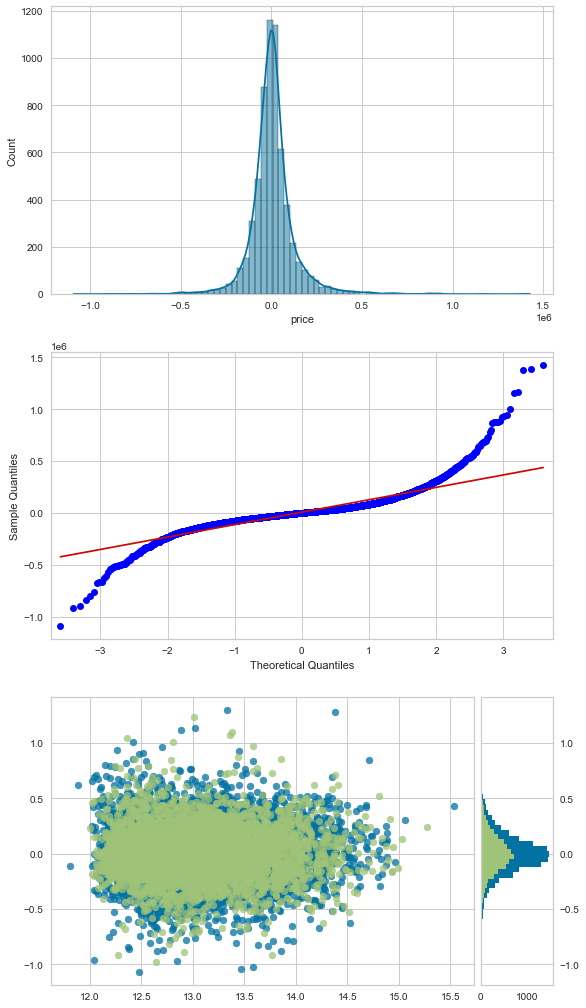

R2_train: 0.854
R2_test: 0.859
Durbin-Watson: 1.994
Train Mean Squarred Error: 16699804004.188
Test Mean Squarred Error: 17374020168.330
Test RMSE: 131810.546


In [89]:
res_plots_log(mlr_9, X_train_scaled_ord, X_test_scaled_ord, y_train_log, y_test_log)

In [90]:

test_preds = mlr_9.predict(X_test_scaled_ord)

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-91-1a9df22ae098>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '1,000,000', '2,000,000', '3,000,000', '4,000,000', '5,000,000'])
<ipython-input-91-1a9df22ae098>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000', '4,500,000'])


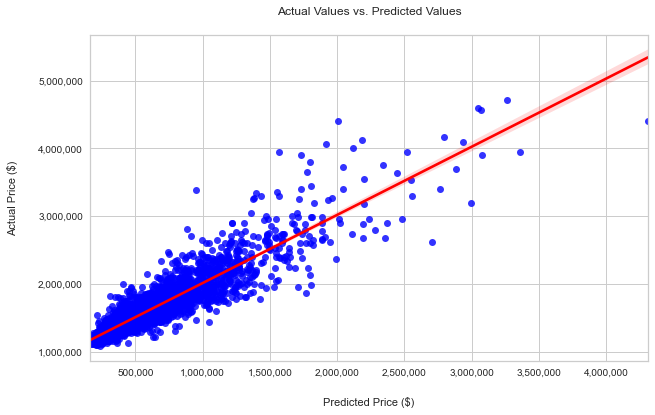

In [91]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(np.exp(test_preds), np.exp(y_test_log), scatter_kws={"color": "blue"}, line_kws={"color": "red"})
ax.set_title('Actual Values vs. Predicted Values', pad=20)
ax.set_ylabel('Actual Price ($)', labelpad=20)
ax.set_xlabel('Predicted Price ($)', labelpad=20)
ax.set_yticklabels(['0', '1,000,000', '2,000,000', '3,000,000', '4,000,000', '5,000,000'])
ax.set_xticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000', '4,500,000'])
plt.savefig('Images/preds_actual_regplot.png', bbox_inches='tight')


In [92]:
X_train_enc = X_train_enc.drop(columns= ['bedrooms','basement'])
X_test_enc = X_test_enc.drop(columns= ['bedrooms','basement'])

In [93]:
# use this for inferrencial
# un-loged and un-scaled 
col_use = X_train_enc
mlr_10_unscaled = LinearRegression()
mlr_10_unscaled.fit(X_train_enc, y_train)
print(mlr_10_unscaled.score(X_train_enc, y_train))
print(mlr_10_unscaled.score(X_test_enc, y_test))

0.7920735627496038
0.7920328045983807


In [94]:
mlr_10_unscaled_ols = sm.OLS(y_train, sm.add_constant(X_train_enc))
mlr_10_unscaled_ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     590.0
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:21:35   Log-Likelihood:            -1.6807e+05
No. Observations:               12628   AIC:                         3.363e+05
Df Residuals:                   12546   BIC:                         3.369e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.133e+05   1.34e+04     -8.440      0.000    -1.4e+05    -8.7e+04
ohe__x0_YES        5.166e+05   1.99e+04     25.931      0.000    4.78e+05    5.56e+05
ohe__x1_EXCELLENT  2.589e+05    1.5e+04     17.230      0.000    2.29e+05    2.88e+05
ohe__x1_FAIR       1.588e+04   1.26e+04      1.255      0.209   -8912.981    4.07e+04
ohe__x1_GOOD       1.014e+05   1.09e+04      9.274      0.000       8e+04    1.23e+05
ohe__x1_NONE      -7.302e+04   6611.826    -11.044      0.000    -8.6e+04   -6.01e+04
ohe__x2_Fair       6483.5836   1.55e+04      0.417      0.677    -2.4e+04     3.7e+04
ohe__x2_Good       1.121e+04   3194.078      3.510      0.000    4950.866    1.75e+04
ohe__x2_Poor      -9.426e+04    3.3e+04     -2.859      0.004   -1.59e+05   -2.96e+04
ohe__x2_Very Good  5.188e+04   5117.751     10.137      0.000    4.18e+04    6.19e+04
ohe__x3_98002       2.47e+04   1.67e+04      1.480      0.139   -8003.995    5.74e+04
ohe__x3_98003      9301.8649   1.49e+04      0.624      0.532   -1.99e+04    3.85e+04
ohe__x3_98004      8.012e+05   1.51e+04     53.155      0.000    7.72e+05    8.31e+05
ohe__x3_98005      3.427e+05    1.7e+04     20.126      0.000    3.09e+05    3.76e+05
ohe__x3_98006       3.04e+05   1.36e+04     22.408      0.000    2.77e+05    3.31e+05
ohe__x3_98007      2.776e+05   1.98e+04     14.047      0.000    2.39e+05    3.16e+05
ohe__x3_98008      2.631e+05   1.49e+04     17.711      0.000    2.34e+05    2.92e+05
ohe__x3_98010      6.877e+04   2.19e+04      3.143      0.002    2.59e+04    1.12e+05
ohe__x3_98011      1.301e+05   1.63e+04      7.958      0.000     9.8e+04    1.62e+05
ohe__x3_98014      1.241e+05   2.06e+04      6.013      0.000    8.36e+04    1.65e+05
ohe__x3_98019      9.303e+04   1.67e+04      5.575      0.000    6.03e+04    1.26e+05
ohe__x3_98022      1.284e+04   1.62e+04      0.793      0.428   -1.89e+04    4.46e+04
ohe__x3_98023     -2.323e+04   1.29e+04     -1.799      0.072   -4.85e+04    2079.193
ohe__x3_98024       1.86e+05   2.22e+04      8.373      0.000    1.42e+05     2.3e+05
ohe__x3_98027       1.81e+05   1.39e+04     12.991      0.000    1.54e+05    2.08e+05
ohe__x3_98028      1.206e+05   1.52e+04      7.946      0.000    9.08e+04     1.5e+05
ohe__x3_98029      2.427e+05   1.44e+04     16.842      0.000    2.14e+05    2.71e+05
ohe__x3_98030       865.6454    1.5e+04      0.058      0.954   -2.86e+04    3.03e+04
ohe__x3_98031      1.712e+04   1.55e+04      1.103      0.270   -1.33e+04    4.75e+04
ohe__x3_98032      5671.6688   1.92e+04      0.296      0.767   -3.19e+04    4.33e+04
ohe__x3_98033      3.811e+05   1.35e+04     28.278      0.000    3.55e+05    4.08e+05
ohe__x3_98034      2.206e+05   1.28e+04     17.247      0.000    1.96e+05    2.46e+05
ohe__x3_98038      3.183e+04   1.26e+04      2.520      0.012    7074.959

In [95]:
# $170 increase in price per 1 sqft increase
# $61 increase in price per 1 sqft increase in nearest 15 neighbors
# $9,344 increase in price per 1 bathroom increase
# $516,600 increase in price if waterfront 
# $73,020 decrease in price if no view
# $15,880 increase in price if fair view
# $101,400 increase in price if good view
# $258,900 increase in price if excellent view

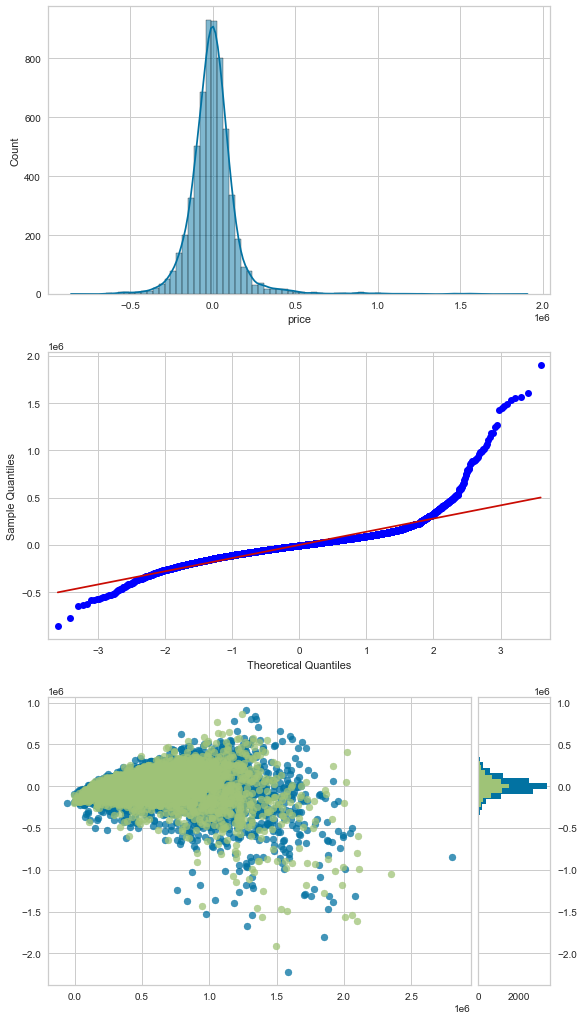

R2_train: 0.792
R2_test: 0.792
Durbin-Watson: 1.960
Train Mean Squarred Error: 21289406165.553
Test Mean Squarred Error: 24335738700.576
Test RMSE: 155999.162


In [97]:
res_plots(mlr_10_unscaled, X_train_enc, X_test_enc, y_train, y_test)

In [98]:
concat_train = pd.concat([X_train_ord[['bathrooms', 'sqft_living', 'waterfront', 'view', 'sqft_living15']], y_train], axis=1)

In [99]:
concat_test = pd.concat([X_test_ord[['bathrooms', 'sqft_living', 'waterfront', 'view', 'sqft_living15']], y_test], axis=1)

In [100]:
visualization_df = pd.concat([concat_train, concat_test])
visualization_df

,bathrooms,sqft_living,waterfront,view,sqft_living15,price
7042,1.75,1990.0,0.0,0.0,1820.0,328000.0
10640,1.00,1410.0,0.0,0.0,1400.0,295832.0
14306,2.75,1350.0,0.0,0.0,1410.0,405500.0
11558,1.50,1550.0,0.0,0.0,1970.0,510000.0
7208,2.75,2990.0,0.0,0.0,2990.0,779950.0
...,...,...,...,...,...,...
13951,1.00,1370.0,0.0,0.0,1690.0,720000.0
7611,1.75,1220.0,0.0,0.0,1240.0,257000.0
3852,2.50,2880.0,0.0,3.0,2470.0,535000.0
1986,1.00,1560.0,0.0,0.0,1890.0,627500.0


C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-101-ca1110520ac1>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])


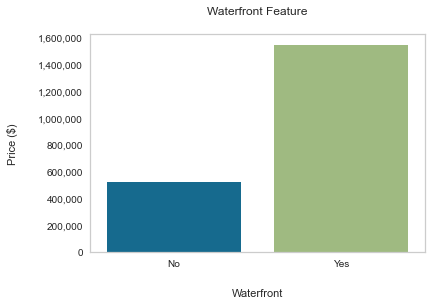

In [101]:
# categorical features
    
fig, ax = plt.subplots()
    
sns.barplot('waterfront', 'price', data=visualization_df, ci=None),
ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xticklabels(['No', 'Yes'])
ax.set_xlabel('Waterfront', labelpad=20)
ax.grid(False)
ax.set_title('Waterfront Feature', pad=20)
plt.savefig('Images/waterfront_bar.png', bbox_inches='tight')

plt.show()

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-102-5f369c5c4d2c>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])


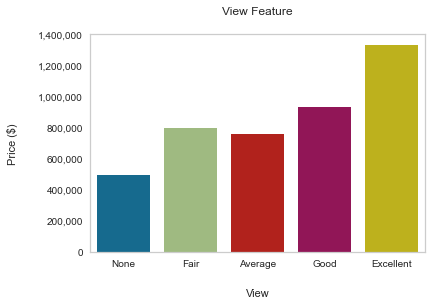

In [102]:
fig, ax = plt.subplots()
    
sns.barplot('view', 'price', data=visualization_df, ci=None),
ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xticklabels(['None', 'Fair', 'Average', 'Good', 'Excellent'])
ax.set_xlabel('View', labelpad=20)
ax.grid(False)
ax.set_title('View Feature', pad=20)
plt.savefig('Images/view_bar.png', bbox_inches='tight')

plt.show()

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-103-1410437c1db3>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])


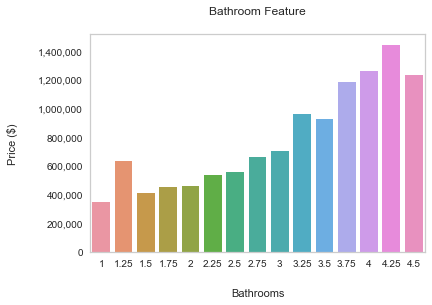

In [103]:
fig, ax = plt.subplots()
    
sns.barplot('bathrooms', 'price', data=visualization_df, ci=None),
ax.set_yticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000', '1,400,000', '1,600,000', '1,800,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xticklabels(['1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3', '3.25', '3.5', '3.75', '4', '4.25','4.5'])
ax.set_xlabel('Bathrooms', labelpad=20)
ax.grid(False)
ax.set_title('Bathroom Feature', pad=20)
plt.savefig('Images/bathroom_bar.png', bbox_inches='tight')

plt.show()

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-104-3fc54aa5208b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000'])


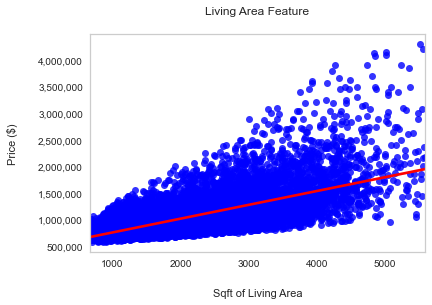

In [104]:
# numerical features

fig, ax = plt.subplots()
    
sns.regplot('sqft_living', 'price', data=visualization_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
ax.set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xlabel('Sqft of Living Area', labelpad=20)
ax.grid(False)
ax.set_title('Living Area Feature', pad=20)
plt.savefig('Images/sqft_living_regplot.png', bbox_inches='tight')

plt.show()

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-105-ae557278d210>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000'])


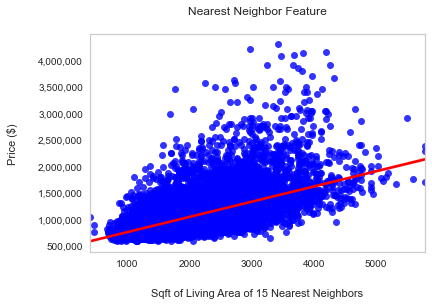

In [105]:
fig, ax = plt.subplots()
    
sns.regplot('sqft_living15', 'price', data=visualization_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
ax.set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000', '4,000,000'])
ax.set_ylabel('Price ($)', labelpad=20)
ax.set_xlabel('Sqft of Living Area of 15 Nearest Neighbors', labelpad=20)
ax.grid(False)
ax.set_title('Nearest Neighbor Feature', pad=20)
plt.savefig('Images/sqft_living15_regplot.png', bbox_inches='tight')

plt.show()

In [106]:
# inferencial: looking at coefficients, and which make the biggest impact on price, and by how much. 
# talk about specific coefficients/variables and how they affect price per 1 unit increase
# if these are the features we pick, talk about how a 1 unite increase in blank will yield an x increase in price
# use coefficients
# breaking assumptions?
# you can violate assumptions and still have a decent predictive model. 
# If you violate assumptions, your inferencial model is less robust your coefficient interpretation. 

In [107]:
# predictive: R2 value and RMSE 
# want a higher R2 in general. want difference between R2_train and R2_test to be neglible. 
# want RMSE to be lower, less dollars you're off by. Compare this RMSE to RMSE of other models. 

In [ ]:
#in conclusion, how does model offer competitive edge? include in slide. be more specific in recommendations 